<a href="https://colab.research.google.com/github/futartup/S8-assignment/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Add the current path to system path so that it can find the custom libraries

In [0]:
import os, sys
if '/content/drive/My Drive/Colab Notebooks/S8' not in sys.path:
  sys.path.append('/content/drive/My Drive/Colab Notebooks/S8')

# Import all the custom and inbuilt modules

In [0]:
try:
  import ipynb
except:
  !pip install ipynb --upgrade
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
import os, sys

from torchsummary import summary
import torch.optim as optim
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms.functional as F



# custom apis
from ipynb.fs.full.transform_train_test_loader import *
from ipynb.fs.full.conf import *
from ipynb.fs.full.train import train_model
from ipynb.fs.full.copy_test import test_model
from ipynb.fs.full.utils import *
from ipynb.fs.full.lr_finder import *
# import gradcam 
from ipynb.fs.full.resnet_gradcam import *


# The model related code. Load the model from the conf file. 

In [4]:

if custom_model['use']:
  #use custom model
  pass
elif inbuilt_model['use']:
  from ipynb.fs.full.model.pytorch_resnet import *
  from ipynb.fs.full.model.resnet import *
  from ipynb.fs.full.model.QuizDNN import *
  model_type = inbuilt_model['model']
  net = globals()[model_type]()
  #net = torchvision.models.resnet18(pretrained=False)

Current Date/Time:  2020-03-24 13:58:46.495859


# Model Summary

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = net.to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

# Test and Train loader

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

train_loader = get_train_loader()
test_loader = get_test_loader()


Files already downloaded and verified
Files already downloaded and verified


# Find the best LR

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


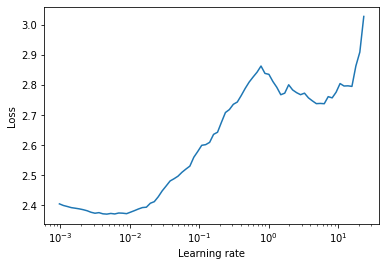

{'lr': [0.0002600215816966161, 0.00029648252167188634, 0.00033805611474005, 0.00038545927115262574, 0.0004395094282846027, 0.0005011386468236528, 0.0005714096835656893, 0.0006515343179819404, 0.0007428942485875672, 0.0008470649194564509, 0.0009658426877552915, 0.0011012758007839154, 0.0012556997167012093, 0.0014317773780202058, 0.0016325451323632057, 0.001861465092351239, 0.0021224848375409606, 0.0024201054879310333, 0.0027594593229224302, 0.00314639828422244, 0.003587594888868818, 0.004090657292555191, 0.004664260487451827, 0.0053182958969449886, 0.006064041946961271, 0.006914358555271299, 0.007883908892617485, 0.008989412239795859, 0.010249932301052074, 0.0116872059455732, 0.013326018046013983, 0.0151946288779102, 0.01732526145021103, 0.019754657170636437, 0.022524709427956393, 0.025683186016916434, 0.02928455286356952, 0.033390913255635125, 0.038073078774317586, 0.04341179039512374, 0.049499110814789575, 0.05644001201411021, 0.06435418543318831, 0.07337810597442479, 0.08366738542567

In [7]:
if use_lr_finder_train:
  lr_finder = LRFinder(model, optimizer, criterion, device) #implemented LRFinder for SGD
  lr_finder.range_test(train_loader, end_lr=100, num_iter=100)
  lr_finder.plot() # to inspect the loss-learning rate graph
  print(lr_finder.history) # see the history
  min_pos = lr_finder.history['loss'].index(min(lr_finder.history['loss']))
  optimizer.lr = lr_finder.history['lr'][min_pos]
  lr_finder.reset()

scheduler = ReduceLROnPlateau(optimizer, 'min')

# Test and Train

In [8]:
# Containers to plot the graph for test and train
test_losses = []
test_acc = []
train_losses = []
train_acc = []

# Containers for correctly and falsely predicted images
correct_predicted = []
false_predicted = []

# Number of images to display which are correct and false predicted
sample_count = 5

# TODO: Take the end epoch value from conf file 
for e in range(1, 2):
    print("epoch no: " , e)
    train_model(model, device, 
                train_loader, optimizer, 
                criterion, e,
                train_losses, train_acc)
    test_loss = test_model(model, device, 
               test_loader, criterion, 
               2, sample_count,
               correct_predicted, false_predicted, 
               test_losses, test_acc)
    scheduler.step(test_loss)
    print("===========================================================\n")



  0%|          | 0/782 [00:00<?, ?it/s]

epoch no:  1


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=52.7979850769043 Batch_id=781 Accuracy=14.20: 100%|██████████| 782/782 [01:41<00:00,  7.73it/s]



Test set: Average loss: 2.6007, Accuracy: 10267/50000 (20.53%)




# *GradCam* for Resnet for falsely predicted images


ship
dog
frog
airplane
dog


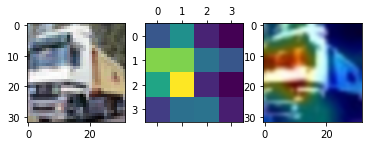

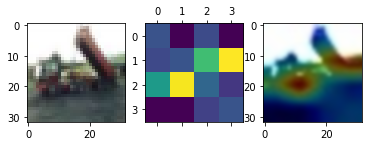

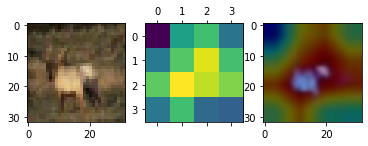

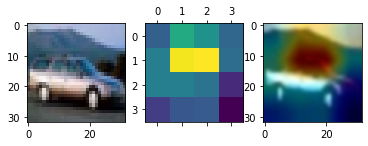

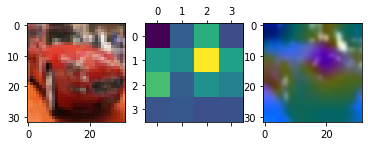

In [18]:
classes = {
    0 : "airplane",
    1 : "automobile",
    2 : "bird",
    3 : "cat",
    4 : "deer",
    5 : "dog",
    6 : "frog",
    7 : "horse",
    8 : "ship",
    9 : "truck",
}
images = [x['image'].unsqueeze(0) for x in false_predicted]
inputs = [i.to(device) for i in images]
gradcamof(model, inputs, classes)

# Correctly predicted images

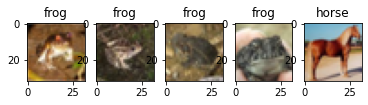

In [19]:
matplotlib_imshow(classes, correct_predicted, plt, False)

# Falsely predicted images

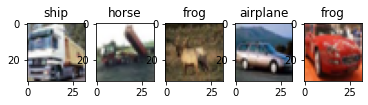

In [20]:
matplotlib_imshow(classes, false_predicted, plt, False)

# Plot The Graph for train and test 

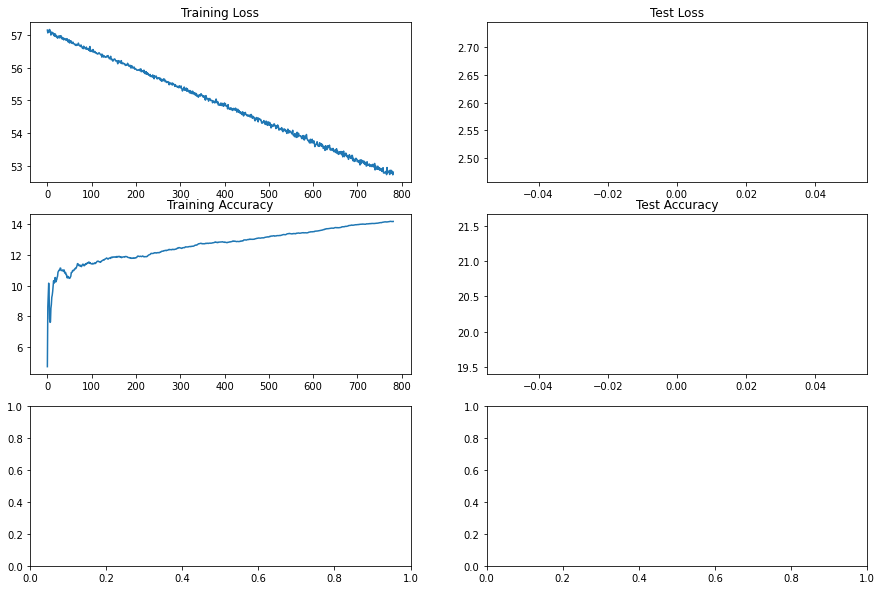

In [21]:
plottesttraingraph(train_losses, train_acc, test_losses, test_acc, plt)